In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import os

D:\anaconda3\envs\DL-Tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
x_train=np.load('../dataset/fashion_mnist_AC_train_60000x128x128.npy')
y_train=np.load('../dataset/fashion_mnist_object_train_60000x128x128.npy')

x_test=np.load('../dataset/fashion_mnist_AC_test_10000x128x128.npy')
y_test=np.load('../dataset/fashion_mnist_object_test_10000x128x128.npy')

In [3]:
from keras.models import Model
from keras.layers import Input, MaxPooling2D, UpSampling2D, Dropout, Conv2D, Concatenate, Activation
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization # error fix
from keras.regularizers import l2

def get_AC(image):
    f = tf.signal.rfft2d(image)
    AC = tf.signal.ifft2d(tf.cast(tf.square(tf.math.abs(f)),dtype=tf.complex64))
    AC = tf.cast(tf.math.abs(tf.signal.ifftshift(AC)),dtype=tf.float32)
    return AC

#  归一化矩阵
def normalization(data):
    _range = tf.reduce_max(data) - tf.reduce_min(data)
    tf.print(_range)
    tf.print('\n')
    return tf.divide(tf.subtract(data , tf.reduce_min(data)), _range )


def ac_loss_function(y_true,y_pred):
    y_true_ac=normalization(get_AC(y_true))
    y_pred_ac=normalization(get_AC(y_pred))
    
    loss=tf.reduce_mean(tf.abs(tf.subtract(y_true_ac,y_pred_ac)))
    #tf.print(y_pred)
    #tf.print(tf.subtract(y_true_ac,y_pred_ac))
    return loss

In [4]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   # x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.BatchNormalization()(x)
   x=layers.Activation('relu')(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   #p = layers.Dropout(0.3)(p)

   return f, p
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same", kernel_initializer='he_normal')(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   # x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [5]:
def build_unet_model():
 # inputs
   inputs = layers.Input(shape=(128,128,1))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 32)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 64)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 128)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 256)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 512)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 256)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 128)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 64)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 32)
   # outputs
   outputs = layers.Conv2D(1, 1, padding="same",activation="relu")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [6]:
model = build_unet_model()
lr_rate=0.01
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='MeanSquaredError',metrics='accuracy')

#checkpoint_save_path = "./checkpoint/unet_AC_rectify.ckpt"
#if os.path.exists(checkpoint_save_path + '.index'):
#    print('-------------load the model-----------------')
#    model.load_weights(checkpoint_save_path)

#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,save_weights_only=True)

batch_size=32
num_epochs=5

#history = model.fit(x_train[0:10000], y_train[0:10000], batch_size=batch_size, epochs=num_epochs, verbose=1, shuffle=True, validation_freq=1,callbacks=[cp_callback], validation_data = (x_test[0:500], y_test[0:500]))
history = model.fit(x_train[0:10000], y_train[0:10000], batch_size=batch_size, epochs=num_epochs, verbose=1, shuffle=True, validation_freq=1, validation_data = (x_test[0:500], y_test[0:500]))

Epoch 1/5
313/313 [==============================] - 38s 88ms/step - loss: 0.0161 - accuracy: 0.8936 - val_loss: 0.0282 - val_accuracy: 0.8928
Epoch 2/5
313/313 [==============================] - 26s 83ms/step - loss: 0.0117 - accuracy: 0.8952 - val_loss: 0.0140 - val_accuracy: 0.8935
Epoch 3/5
313/313 [==============================] - 26s 82ms/step - loss: 0.0112 - accuracy: 0.8954 - val_loss: 0.0114 - val_accuracy: 0.8938
Epoch 4/5
313/313 [==============================] - 26s 83ms/step - loss: 0.0080 - accuracy: 0.8955 - val_loss: 0.0081 - val_accuracy: 0.8936
Epoch 5/5
313/313 [==============================] - 28s 89ms/step - loss: 0.0054 - accuracy: 0.8957 - val_loss: 0.0068 - val_accuracy: 0.8940


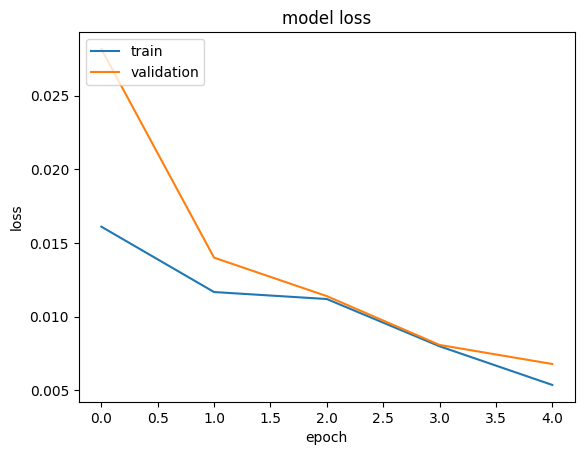

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('total_loss_4.png')
plt.show()
plt.close()

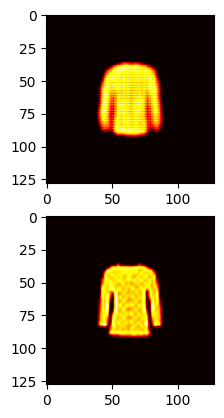

In [13]:
index=int(np.random.randint(x_test.shape[0], size=1))
a=x_test[index]
a=a[np.newaxis,:]
predict_results=model.predict(a)
predict_results=tf.squeeze(predict_results)
plt.subplot(2,1,1)
plt.imshow(predict_results, cmap='hot')
plt.subplot(2,1,2)
plt.imshow(y_test[index], cmap='hot') 

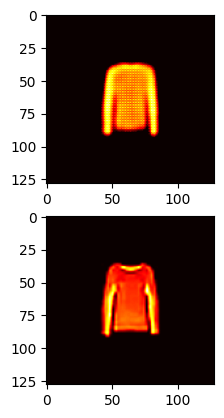

In [15]:
index=int(np.random.randint(x_test.shape[0], size=1))
a=x_train[index]
a=a[np.newaxis,:]
predict_results=model.predict(a)
predict_results=tf.squeeze(predict_results)
plt.subplot(2,1,1)
plt.imshow(predict_results, cmap='hot')
plt.subplot(2,1,2)
plt.imshow(y_train[index], cmap='hot') 